# **Lab4 Notebook Solution for the Final Challenge - Roberto Losada García**

In [1]:
# # You can shutdown the kernel by running this cell:
# import IPython
# IPython.Application.instance().kernel.do_shutdown(True)
# # Wait for it

In [2]:
# Handy function to see arguments of functions and classes:
import inspect
def insp(x):
    return inspect.signature(x)

# Final challenge: Computing reaction energy of C + C<sub>2</sub>H<sub>2</sub> →C<sub>3</sub>H<sub>2</sub>

**This is an exercise for you to completely design the approach yourself from ground up to get the best result for a noisy simulation run!**

Here we will ask you to follow reaction processes which Cyclopropenylidene is involved in. This reaction process is related to the creation of $C_3H_2$:

$$C + C_2H_2 → C_3H_2$$

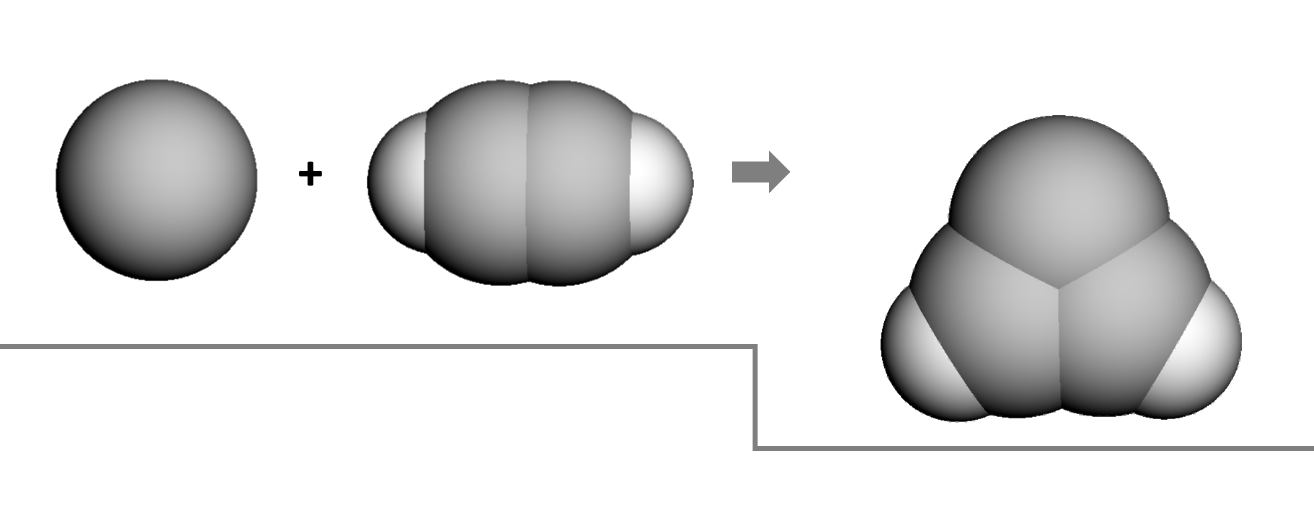

For this challenge, we will provide you a classical quantum chemistry computation reference value as computed by Dr. Yukio Kawashima Sensei.

<div class="alert alert-block alert-info">
    <b>Reference Value</b>
    
    
- Chemistry engine: Pyscf, version 2.0.1
- Python version: 3.9.12
- Computation options used: 
    - method: CCSD
    - basis: cc-pVDZ

    
**Expected Reaction energy: -4.26923078561136 eV**

</div>

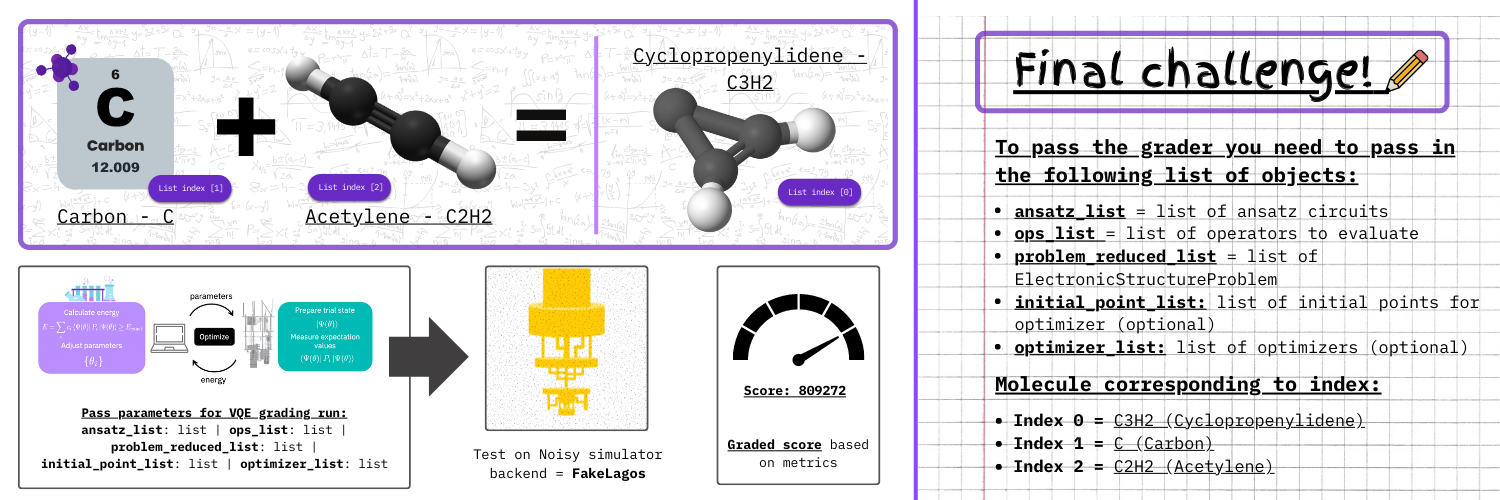

# Preliminary configuration:

## Configure IBM acccount and grader:

In [3]:
# #Load IBM account & configure grader:
# token = 'token'
# hub = 'hub'
# group = 'group'
# project = 'project'

In [24]:
# from qiskit import IBMQ
# # If you have you already saved your account just run the .load_account()
# # IBMQ.save_account(token)
# provider = IBMQ.load_account()
# backend = provider.get_backend('ibmq_qasm_simulator')
# provider_2 = IBMQ.get_provider(hub=hub, group=group, project=project)
# display(IBMQ.active_account())
# display(IBMQ.providers())

# import qc_grader
# # qc_grader.__version__
# %env QXToken=token
# %env QC_GRADING_ENDPOINT=https://qac-grading.quantum-computing.ibm.com
# %env QXAuthURL=https://auth.quantum-computing.ibm.com/api
# %env QC_GRADE_ONLY=true
# import os
# print((os.environ['QXToken'],
#        os.environ['QC_GRADING_ENDPOINT'],
#        os.environ['QXAuthURL']))

In [5]:
#This cell will make our life easier by printing all the content of a cell in the notebook:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Default config in case you don't want it:
# InteractiveShell.ast_node_interactivity = "last_expr" 

## Import necessary libraries and packages:

In [6]:
# import math
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer, BasicAer, IBMQ, QuantumCircuit
from qiskit.primitives import Sampler, Estimator, BackendEstimator
from qiskit.providers.aer import StatevectorSimulator, AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeManilaV2, FakeAthensV2, FakeAthens, FakeLagos
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.utils.mitigation import CompleteMeasFitter

from qiskit.tools.jupyter import *
from qiskit.visualization import *

In [7]:
# Import Qiskit libraries for VQE

from qiskit.algorithms.minimum_eigensolvers import VQE, AdaptVQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA, GradientDescent, NFT
from qiskit.algorithms.optimizers import COBYLA, SLSQP, CG, CG, NELDER_MEAD, POWELL, SNOBFIT, TNC, UMDA, L_BFGS_B, OptimizerResult
from qiskit_nature.second_q.problems import EigenstateResult
# For more info, check:
# https://github.com/Qiskit/qiskit-terra/tree/324c875eba29711ded4471eaa76f07cc44a6a820/qiskit/algorithms/optimizers

from functools import partial
from scipy.optimize import minimize

from qiskit.opflow import Z2Symmetries, TwoQubitReduction
from qiskit.circuit.library import EfficientSU2, TwoLocal, RealAmplitudes, PauliTwoDesign
# from qiskit.algorithms.eigensolvers import VQD
# from qiskit.algorithms.state_fidelities import ComputeUncompute

# Import Qiskit Nature libraries
from qiskit_nature.second_q.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit_nature.second_q.circuit.library import UCCSD, UCC, UVCC, HartreeFock, SUCCD, PUCCD
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import (
    QubitConverter, FermionicMapper, ParityMapper,BravyiKitaevMapper, JordanWignerMapper,
    BravyiKitaevSuperFastMapper) #, QubitMapper, DirectMapper)
# from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
# from qiskit_nature.properties.second_quantization.electronic import ElectronicEnergy
# from qiskit_nature.properties.second_quantization.electronic.bases import ElectronicBasis
from qiskit_nature.second_q.problems import EigenstateResult
from qiskit_nature.second_q.transformers import BaseTransformer, ActiveSpaceTransformer, FreezeCoreTransformer
from qiskit_nature.settings import settings
settings.dict_aux_operators = True # Make aux operators dict-based

In [8]:
# Prototype-zne
!pip install prototype-zne --quiet'

from zne import zne
from zne import ZNEStrategy
from zne.extrapolation import PolynomialExtrapolator, LinearExtrapolator
from zne.noise_amplification import LocalFoldingAmplifier, GlobalFoldingAmplifier

/bin/bash: -c: línea 0: EOF inesperado mientras se buscaba un `'' coincidente
/bin/bash: -c: línea 1: error sintáctico: no se esperaba el final del fichero


In [9]:
# We fix a seed for reproducibility purposes:
seed = 42
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = seed

# Function to construct the hamiltonians of the molecules:

In [10]:
def def_problem(molecule_info,driver_type=None,transformation=None,
                mapper=None,twoqred=True,Z2symred=True,disp=False):
    
    # Unpacking info of the molecule
    if len(molecule_info)==7:
        geometry,charge,multiplicity,basis,num_electrons,num_spatial_orbitals,masses = molecule_info
    elif len(molecule_info)==6:
        geometry,charge,multiplicity,basis,num_electrons,num_spatial_orbitals = molecule_info
    else:
        print("Error in molecule_info")

    # Building the molecule
    symbols,coords = geometry         
    molecule = MoleculeInfo(symbols=symbols,coords=coords,multiplicity=multiplicity,
                            charge=charge,masses=None)
    
    # Driver to run the molecule
    if driver_type == None:
        driver = PySCFDriver.from_molecule(molecule, basis=basis)
    else:
        driver = driver_type.from_molecule(molecule, basis=basis)
        
    problem = driver.run()
    
    # For more iinfo about Inside driver.run().properties check here:
    # https://qiskit.org/documentation/nature/tutorials/09_properties.html
    def print_properties(driver_running):
        print("Molecule info: " , driver_running.molecule)
        print("Molecule basis: " , driver_running.basis)

        print("number of particles: " , driver_running.num_particles)
        print("number of alpha electrons: " , driver_running.num_alpha)
        print("number of beta electrons: " , driver_running.num_beta)

        print("number of spin orbitals: " , driver_running.num_spin_orbitals)
        print("number of spatial/molecular orbitals: " , driver_running.num_spatial_orbitals)

        print("reference energy: ", driver_running.reference_energy)
        print("nuclear repulsion energy: " , driver_running.nuclear_repulsion_energy)

        print("Orbital energies :",driver_running.orbital_energies)
        print("Orbital energiesb :",driver_running.orbital_energies_b)
        print("Orbital occupations :",driver_running.orbital_occupations)
        print("Orbital occupationsb :",driver_running.orbital_occupations_b)
        # print("Properties:", driver_running.properties)
        # print("Hamiltonian", driver_running.hamiltonian)
    
    if disp == True:
        print( "Non-reduced problem info \n")
        print_properties(problem)
        print("-------------------------------------------------------------------------------------------------------- \n")
        

    # We save the initial problem info
    problem_info = {
        "Problem": problem,
        "Molecule_info": problem.molecule,
        "Molecule_basis": problem.basis,
        "Num_particles": problem.num_particles,
        "Num_alpha_elect": problem.num_alpha,
        "Num_beta_elect": problem.num_beta,
        "Num_spin_orbitals": problem.num_spin_orbitals,
        "Num_spatial_orbitals": problem.num_spatial_orbitals,
        "Reference_energy": problem.reference_energy,
        "Nuclear_repulsion_energy": problem.nuclear_repulsion_energy,
        "Orbital_energies": problem.orbital_energies,
        "Orbital_energies_b": problem.orbital_energies_b,
        "Orbital_occupations": problem.orbital_occupations,
        "Orbital_occupations_b": problem.orbital_occupations_b,
        "Properties": problem.properties,
        "Hamiltonian": problem.hamiltonian}
     
    # Transformation in order to reduce the problem
    if transformation == None:
        transf = ActiveSpaceTransformer(num_electrons=num_electrons,
                                        num_spatial_orbitals=num_spatial_orbitals)
    else:
        transf = transformation(num_electrons=num_electrons,
                                num_spatial_orbitals=num_spatial_orbitals)   
    # About transformers and more...
    # https://qiskit.org/documentation/nature/tutorials/05_problem_transformers.html
    # https://github.com/Qiskit/qiskit-nature/blob/stable/0.5/docs/tutorials/05_problem_transformers.ipynb
    
    # Reduction of the problem
    problem_reduced = transf.transform(problem)
    
    # Retrieve the hamiltonian
    hamiltonian_reduced = problem_reduced.hamiltonian
    
    # Print info about the reduced problem & hamiltonian 
    if disp == True:
        print( "Reduced problem info \n")
        print_properties(problem_reduced)
        print("-------------------------------------------------------------------------------------------------------- \n")
        print( "Hamiltonian (reduced) info")
        print("\n".join(str(hamiltonian_reduced.second_q_op()).splitlines()[:10] + ["..."]))
        print("-------------------------------------------------------------------------------------------------------- \n")
    
    # We save the initial problem info
    problem_reduced_info = {
        "Problem": problem_reduced,
        "Molecule_info": problem_reduced.molecule,
        "Molecule_basis": problem_reduced.basis,
        "Num_particles": problem_reduced.num_particles,
        "Num_alpha_elect": problem_reduced.num_alpha,
        "Num_beta_elect": problem_reduced.num_beta,
        "Num_spin_orbitals": problem_reduced.num_spin_orbitals,
        "Num_spatial_orbitals": problem_reduced.num_spatial_orbitals,
        "Reference_energy": problem_reduced.reference_energy,
        "Nuclear_repulsion_energy": problem_reduced.nuclear_repulsion_energy,
        "Orbital_energies": problem_reduced.orbital_energies,
        "Orbital_energies_b": problem_reduced.orbital_energies_b,
        "Orbital_occupations": problem_reduced.orbital_occupations,
        "Orbital_occupations_b": problem_reduced.orbital_occupations_b,
        "Properties": problem_reduced.properties,
        "Hamiltonian": problem_reduced.hamiltonian,
        "Second_q_main_op": problem_reduced.hamiltonian.second_q_op(),
        "Second_q_second_op": problem_reduced.properties.particle_number.second_q_ops()["ParticleNumber"],
        "Symmetry_sector_locator": problem_reduced.symmetry_sector_locator}
    
    # Select a mapper:
    if mapper==None or mapper=='P':
        mapper = ParityMapper()
    elif mapper=='JW':
        mapper = JordanWignerMapper()
    elif mapper=='BK':
        mapper = BravyiKitaevMapper()
    elif mapper=='BKSF':
        mapper == BravyiKitaevSuperFastMapper()
    else:
        print("Error in mapper type, please select 'P', 'JW', 'BK' or 'BKFS'")
    
    # Whether to implement a Z2symred & 2qubit reduction during the mapping
    if Z2symred == True:
        mapper_converter = QubitConverter(mapper=mapper,
                                          two_qubit_reduction=twoqred,
                                          z2symmetry_reduction='auto')
    elif Z2symred == False:
        mapper_converter = QubitConverter(mapper=mapper,
                                          two_qubit_reduction=twoqred)
    else:
        print("Error in Z2symred")
        
    # Mapping of the Fermionic 2nd q operators to the Qubit Space:
    main_qubit_op = mapper_converter.convert(
        second_q_op=problem_reduced_info["Second_q_main_op"],
        num_particles=problem_reduced_info["Num_particles"],
        sector_locator=problem_reduced_info["Symmetry_sector_locator"])    
        
    second_qubit_op = mapper_converter.convert_match(
        problem_reduced_info["Second_q_second_op"])        
    
    # Info about the mapping process
    mapped_problem_info = {
        "Mapper_type": mapper,
        "Mapper_converter": mapper_converter,
        "2qubitred": twoqred,
        "Z2symred": Z2symred,
        "Main_qubit_op": main_qubit_op,
        "Second_qubit_op": second_qubit_op,
        "Qubit_number": main_qubit_op.num_qubits}
    
    # Print info about the mapping process
    if disp == True:
        print( "Mapping info \n")
        print("Mapper type: ",mapper)
        print("2 qubit reduction: %s // Z2 sym. reduction: %s" % (twoqred,Z2symred) )
        print("Nº of qubits :", main_qubit_op.num_qubits)
        print("Hamiltonian mapped:", main_qubit_op)
        print("-------------------------------------------------------------------------------------------------------- \n")
        
         
    return problem_info, problem_reduced_info, mapped_problem_info

# Hamiltonians for C (c), C<sub>2</sub>H<sub>2</sub> (ac) and C<sub>3</sub>H<sub>2</sub> (cy) molecules

In [11]:
c_geometry = [["C"],[(0.0,0.0,0.0)]]
c_charge=0
c_multiplicity=3
c_basis="631g" #ccpvtz-dk","ccpvtz-dk","sto6g
c_num_electrons=4 #4
c_num_spatial_orbitals=4
# c_masses=None

c_info = [c_geometry,c_charge,c_multiplicity,
               c_basis,c_num_electrons,c_num_spatial_orbitals]

(c_problem_info, c_problem_reduced_info,
 c_mapped_problem_info) = def_problem(molecule_info=c_info,disp=True)

Non-reduced problem info 

Molecule info:  Molecule:
	Multiplicity: 3
	Charge: 0
	Unit: Bohr
	Geometry:
		C	(0.0, 0.0, 0.0)
	Masses:
		C	12
Molecule basis:  ElectronicBasis.MO
number of particles:  (4, 2)
number of alpha electrons:  4
number of beta electrons:  2
number of spin orbitals:  18
number of spatial/molecular orbitals:  9
reference energy:  -37.67686564828303
nuclear repulsion energy:  0
Orbital energies : [-11.31706416  -0.69721286  -0.11767704  -0.11767704   0.07595025
   0.76982248   0.76982248   0.79654119   0.8015303 ]
Orbital energiesb : None
Orbital occupations : [1. 1. 1. 1. 0. 0. 0. 0. 0.]
Orbital occupationsb : [1. 1. 0. 0. 0. 0. 0. 0. 0.]
-------------------------------------------------------------------------------------------------------- 

Reduced problem info 

Molecule info:  Molecule:
	Multiplicity: 3
	Charge: 0
	Unit: Bohr
	Geometry:
		C	(0.0, 0.0, 0.0)
	Masses:
		C	12
Molecule basis:  ElectronicBasis.MO
number of particles:  (3, 1)
number of alpha electron

In [12]:
ac_geometry = [["C","H","C","H"],[(0.0000,    0.0000,   -0.6025),
                                  (0.0000,    0.0000,   -1.6691),
                                  (0.0000,    0.0000,    0.6025),
                                  (0.0000,    0.0000,    1.6691)]]
ac_charge=0
ac_multiplicity=1
ac_basis="ccpvtz-dk" 
ac_num_electrons=4 
ac_num_spatial_orbitals=4

ac_info = [ac_geometry,ac_charge,ac_multiplicity,
               ac_basis,ac_num_electrons,ac_num_spatial_orbitals]

(ac_problem_info, ac_problem_reduced_info,
 ac_mapped_problem_info) = def_problem(molecule_info=ac_info,disp=True)

Non-reduced problem info 

Molecule info:  Molecule:
	Multiplicity: 1
	Charge: 0
	Unit: Bohr
	Geometry:
		C	(0.0, 0.0, -1.1385599900504497)
		H	(0.0, 0.0, -3.1541418745115446)
		C	(0.0, 0.0, 1.1385599900504497)
		H	(0.0, 0.0, 3.1541418745115446)
	Masses:
		C	12
		H	1
		C	12
		H	1
Molecule basis:  ElectronicBasis.MO
number of particles:  (7, 7)
number of alpha electrons:  7
number of beta electrons:  7
number of spin orbitals:  176
number of spatial/molecular orbitals:  88
reference energy:  -76.84738920352612
nuclear repulsion energy:  24.717023304133242
Orbital energies : [-11.24271548 -11.23896393  -1.02766994  -0.76480275  -0.67825303
  -0.40911234  -0.40911234   0.15066325   0.17104661   0.17674681
   0.17674681   0.30915543   0.40823293   0.43455019   0.43455019
   0.51110577   0.57398786   0.57398786   0.60362392   0.77303634
   0.77303634   0.77898888   0.8030633    0.8030633    0.94698878
   1.06957647   1.06957647   1.08181911   1.09595346   1.09595346
   1.18866133   1.459045

In [13]:
cy_geometry = [["C","C","C","H","H"],[(2.2883,    0.6993,    0.3468),
                                      (1.9543,    2.0133,    0.7806),
                                      (1.0108,    0.9522,    0.6802),
                                      (3.0291,    0.0000,    0.0000),
                                      (0.0000,    0.5997,    0.7904)]]
cy_charge=0
cy_multiplicity=1
cy_basis="sto6g" 
cy_num_electrons=2 
cy_num_spatial_orbitals=2

cy_info = [cy_geometry,cy_charge,cy_multiplicity,
               cy_basis,cy_num_electrons,cy_num_spatial_orbitals]

(cy_problem_info, cy_problem_reduced_info,
 cy_mapped_problem_info) = def_problem(molecule_info=cy_info,disp=True)

Non-reduced problem info 

Molecule info:  Molecule:
	Multiplicity: 1
	Charge: 0
	Unit: Bohr
	Geometry:
		C	(4.324260290842231, 1.3214854789083479, 0.6553570199991634)
		C	(3.6930917652375004, 3.8045856065868393, 1.4751202128354872)
		C	(1.9101351667103643, 1.799397215810852, 1.2853917099291552)
		H	(5.724169403920029, 0.0, 0.0)
		H	(0.0, 1.1332687569016675, 1.4936395288562248)
	Masses:
		C	12
		C	12
		C	12
		H	1
		H	1
Molecule basis:  ElectronicBasis.MO
number of particles:  (10, 10)
number of alpha electrons:  10
number of beta electrons:  10
number of spin orbitals:  34
number of spatial/molecular orbitals:  17
reference energy:  -114.29342335694255
nuclear repulsion energy:  52.35878348322772
Orbital energies : [-11.22780545 -11.22671404 -11.12228713  -1.15667481  -0.75805542
  -0.7303048   -0.56898146  -0.42802758  -0.4190444   -0.29237217
   0.26868253   0.3233951    0.56657125   0.58291727   0.59048323
   0.88852687   1.07472248]
Orbital energiesb : None
Orbital occupations : [1

# Ansatzs:

In [14]:
def properties(ansatz):
    print("Ansatz : %s, Nº Params: %d, Depth: %d \n" % (
        ansatz.name,ansatz.num_parameters,ansatz.decompose(reps=6).depth()))
    display(ansatz.decompose(reps=6).draw())
    print("--------------------------------------------- \n")

CY ANSATZ: 

Ansatz : PauliTwoDesign, Nº Params: 4, Depth: 6 



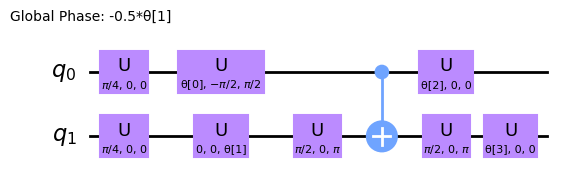

--------------------------------------------- 

C ANSATZ: 

Ansatz : PauliTwoDesign, Nº Params: 6, Depth: 8 



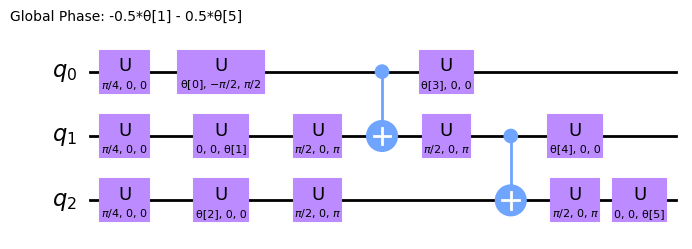

--------------------------------------------- 

AC ANSATZ: 

Ansatz : EfficientSU2, Nº Params: 9, Depth: 9 



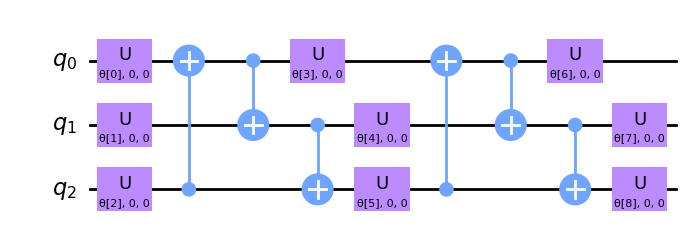

--------------------------------------------- 



In [15]:
cy_ansatz = PauliTwoDesign(num_qubits=cy_mapped_problem_info["Qubit_number"],reps=1,seed=seed)
print("CY ANSATZ: \n")
properties(cy_ansatz)

c_ansatz = PauliTwoDesign(num_qubits=c_mapped_problem_info["Qubit_number"],reps=1,seed=seed)
print("C ANSATZ: \n")
properties(c_ansatz)

print("AC ANSATZ: \n")
ac_ansatz = EfficientSU2(num_qubits=ac_mapped_problem_info["Qubit_number"],
                            su2_gates=['ry'],entanglement='circular',reps=2)
properties(ac_ansatz)

# Estimators:

In [16]:
# Vanilla estimator:
estimator=Estimator()
# backend = BasicAer.get_backend("statevector_simulator")


# Define fake backend (noisy)
# FakeManilaV2, FakeAthensV2, FakeAthens, FakeLagos
noisy_backend = FakeLagos()
noisy_estimator = BackendEstimator(backend=noisy_backend)


# Noisy backend + zne strategy
zne_strategy = ZNEStrategy(
    noise_factors=[1, 2, 3, 4, 5],
    noise_amplifier = LocalFoldingAmplifier(gates_to_fold=2) ,
    extrapolator=PolynomialExtrapolator(degree=2)
)
# ZNEEstimator = zne(BackendEstimator)
# noisy_estimator_zne = ZNEEstimator(backend=noisy_backend, zne_strategy=zne_strategy)

# Checking score with grader:

In order to use the grader, because we are using a different version of the ElectronicStructureProblem, following the migration guide (check it either [here](https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html) or [here](https://github.com/Qiskit/qiskit-nature/blob/stable/0.5/docs/migration/00b_Electronic_structure_with_v0.5.ipynb)). We will need to convert our reduced problem:

Note that our ElectronicStructureProblems comes from the following class ([.py file](https://github.com/Qiskit/qiskit-nature/blob/cd0fcca70df419d19ce975ba047c00a48c527775/qiskit_nature/second_q/problems/electronic_structure_problem.py)):
`qiskit_nature.second_q.problems.electronic_structure_problem.ElectronicStructureProblem `

While the ones that should be submitted come from other one ([.py file](https://github.com/Qiskit/qiskit-nature/blob/cd0fcca70df419d19ce975ba047c00a48c527775/qiskit_nature/problems/second_quantization/electronic/electronic_structure_problem.py)):
`qiskit_nature.problems.second_quantization.electronic.electronic_structure_problem.ElectronicStructureProblem `




### Convert problem to legacy:

In [17]:
# We build a function that creates a legacy reduced problem from the reduced one that we have got
from qiskit_nature.drivers import Molecule
from qiskit_nature.problems.second_quantization.electronic.electronic_structure_problem import (
    ElectronicStructureProblem as legacyElectronicStructureProblem)
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.transformers.second_quantization.electronic import (ActiveSpaceTransformer as oldActiveSpaceTransformer,
                                                                       FreezeCoreTransformer as oldFreezeCoreTransformer)

def legacy_problem(molecule_info: list):
    
    if len(molecule_info)==7:
        geometry,charge,multiplicity,basis,num_electrons,num_spatial_orbitals,masses = molecule_info
    elif len(molecule_info)==6:
        geometry,charge,multiplicity,basis,num_electrons,num_spatial_orbitals = molecule_info
    else:
        print("Error in molecule_info")
        
        
    symbols,coords = geometry
    legacy_geometry = [[a,b] for a,b in zip(symbols,[list(item) for item in coords])]
    # symbols = problem_reduced_info["Molecule_info"].symbols
    # coords = [list(item) for item in problem_reduced_info["Molecule_info"].coords]
    # legacy_geometry = [list(item) for item in product(symbols,coords)]

    legacy_molecule = Molecule(
        geometry=legacy_geometry,
        charge=charge,
        multiplicity=multiplicity)
    
    legacy_driver = ElectronicStructureMoleculeDriver(
        molecule=legacy_molecule,basis=basis,
        driver_type=ElectronicStructureDriverType.PYSCF) 
    
    driver_running = legacy_driver.run()
    
    legacy_active_space_trafo = oldActiveSpaceTransformer(
        num_electrons=num_electrons,num_molecular_orbitals=num_spatial_orbitals)
    
    legacy_problem_reduced = legacyElectronicStructureProblem(
        driver=legacy_driver,transformers=[legacy_active_space_trafo])
    
    # We need to run this line to initialize the problem
    legacy_second_q_ops_reduced = legacy_problem_reduced.second_q_ops()
    
    return legacy_problem_reduced
    
#     num_particles = driver_running.get_property("ParticleNumber").num_particles
#     num_alpha_electrons = driver_running.get_property('ParticleNumber').num_alpha
#     num_beta_electrons = driver_running.get_property('ParticleNumber').num_beta
#     num_spin_orbitals = int(driver_running.get_property('ParticleNumber').num_spin_orbitals)
#     energy_elements=driver_running.get_property("ElectronicEnergy")
#     nuclear_rep_energy = driver_running.get_property('ElectronicEnergy').nuclear_repulsion_energy
    
#     if disp==True:
#         print("number of particles: " , num_particles)
#         print("number of alpha electrons: " , num_alpha_electrons)
#         print("number of beta electrons: " , num_beta_electrons)
#         print("number of spin orbitals: " , num_spin_orbitals)
#         print("Energy elements: " , energy_elements)
#         print("nuclear repulsion energy: " , nuclear_rep_energy)

## Test grader:

In [18]:
# List of ansatz circuits
ansatz_list = [cy_ansatz, c_ansatz, ac_ansatz] 

# List of operators
ops_list = [cy_mapped_problem_info["Main_qubit_op"],
            c_mapped_problem_info["Main_qubit_op"],
            ac_mapped_problem_info["Main_qubit_op"]] 

# List of ElectronicStrucutreProblem (not valid for grader)
# problem_reduced_list = [cy_problem_reduced_info["Problem"],
#                         c_problem_reduced_info["Problem"],
#                         ac_problem_reduced_info["Problem"]] 

# List of ElectronicStrucutreProblem (legacy for the grader)
legacy_problem_reduced_list = [legacy_problem(cy_info),
                               legacy_problem(c_info),
                               legacy_problem(ac_info)]

In [19]:
initial_c = [3.141451071177721, 2.194666105536474, 5.495649779086331-2*np.pi,
             3.7517046549353847-2*np.pi, -1.5747582651758965, 0.38562937159067345]

# List of initial points
initial_cy = [-0.0025550275017059286, 3.1245080811142127, 2.525895285128535, 0.6174738123820769]
initial_c = [3.141451071177721, 2.194666105536474, -0.7875355280932554,
             -2.5314806522442015, -1.5747582651758965, 0.38562937159067345]
initial_ac = [0.7321904385062634, 3.1446692435490826, 1.6027647396835174, 3.018690114040735,
              0.12606962733708738, -0.12667917537097947, -1.5394298184958932, 2.2767108277832717,
              -0.002521208427807108]

initial_point_list = [initial_cy,initial_c,initial_ac]
optimizer_list = [SLSQP(maxiter=1),SLSQP(maxiter=1),SLSQP(maxiter=1)]

In [20]:
%%time
algorithm_globals.random_seed = seed

from qc_grader.challenges.fall_2022 import grade_lab4_final

grade_lab4_final(
    ansatz_list=ansatz_list,
    ops_list=ops_list,
    problem_reduced_list=legacy_problem_reduced_list,
    initial_point_list=initial_point_list,
    optimizer_list=optimizer_list)

Running VQE....... 1
VQE run 1 complete
Converged value for run 1 is: (-114.2188999944645+0j)
Result for run 1: {   'fun': -1.068366642543407,
    'jac': None,
    'nfev': 5,
    'nit': 1,
    'njev': 1,
    'x': array([-2.55502750e-03,  3.12450808e+00,  2.52589529e+00,  6.17473812e-01])} 

Running VQE....... 2
VQE run 2 complete
Converged value for run 2 is: (-37.519156981949045+0j)
Result for run 2: {   'fun': -5.1622872179043044,
    'jac': None,
    'nfev': 7,
    'nit': 1,
    'njev': 1,
    'x': array([ 3.14145107,  2.19466611, -0.78753553, -2.53148065, -1.57475827,
        0.38562937])} 

Running VQE....... 3
VQE run 3 complete
Converged value for run 3 is: (-76.62771667390686+0j)
Result for run 3: {   'fun': -4.067569531274025,
    'jac': None,
    'nfev': 10,
    'nit': 1,
    'njev': 1,
    'x': array([ 7.32190439e-01,  3.14466924e+00,  1.60276474e+00,  3.01869011e+00,
        1.26069627e-01, -1.26679175e-01, -1.53942982e+00,  2.27671083e+00,
       -2.52120843e-03])} 

Gradi

In [21]:
%%time
algorithm_globals.random_seed = seed 
grade_lab4_final(
    ansatz_list=ansatz_list,
    ops_list=ops_list,
    problem_reduced_list=legacy_problem_reduced_list,
    initial_point_list=initial_point_list,
    optimizer_list=optimizer_list,
    zne_strategy=zne_strategy)

Running VQE....... 1
VQE run 1 complete
Converged value for run 1 is: (-114.1190132444685+0j)
Result for run 1: {   'fun': -0.968479892547395,
    'jac': None,
    'nfev': 5,
    'nit': 1,
    'njev': 1,
    'x': array([-2.55502750e-03,  3.12450808e+00,  2.52589529e+00,  6.17473812e-01])} 

Running VQE....... 2
VQE run 2 complete
Converged value for run 2 is: (-37.142315200080745+0j)
Result for run 2: {   'fun': -4.785445436036006,
    'jac': None,
    'nfev': 7,
    'nit': 1,
    'njev': 1,
    'x': array([ 3.14145107,  2.19466611, -0.78753553, -2.53148065, -1.57475827,
        0.38562937])} 

Running VQE....... 3
VQE run 3 complete
Converged value for run 3 is: (-75.65391728613244+0j)
Result for run 3: {   'fun': -3.0937701434996048,
    'jac': None,
    'nfev': 10,
    'nit': 1,
    'njev': 1,
    'x': array([ 7.32190439e-01,  3.14466924e+00,  1.60276474e+00,  3.01869011e+00,
        1.26069627e-01, -1.26679175e-01, -1.53942982e+00,  2.27671083e+00,
       -2.52120843e-03])} 

Gradi

In [22]:
from qiskit.tools.jupyter import *
%qiskit_version_table